In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [3]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [5]:
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
# from game import VDMotorEstimationSolver

# Ground truth motor

In [6]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0))
noise_motor = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
print(motor)
print(noise_motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 1 0 0.031 0 0.0048 0.005 0.0052 -0.00016 ]


# Dataset

In [7]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

In [8]:
planes_b_noisy = [plane.spin(motor).spin(noise_motor) for plane in planes_a]

In [9]:
planes_a[0] * planes_b[0]

Mot: [ 0.63 0.24 0.63 0.38 1.3 0.87 0.21 0 ]

In [10]:
a = planes_a[0]; print(a)
b = planes_b[0]; print(b)

Dlp: [ 0.8503 0.5213 0.03148 -0.2147 ]
Dlp: [ 0.3979 0.5213 0.7522 1.457 ]


In [11]:
np.array(b * a) - np.array(a * b) 

array([ 0.    , -0.4717, -1.2541, -0.7513, -2.6481, -1.7424, -0.4147,  0.    ])

In [12]:
a ^ b

TypeError: unsupported operand type(s) for ^: 'versor_pybind11.Dlp' and 'versor_pybind11.Dlp'

In [13]:
A = a.vec().duale()
da = np.array(a)[3]
B = b.vec().duale()
db = np.array(b)[3]

In [14]:
Ap = vsr.Mot(0,A[0],A[1],A[2],0,0,0,da)
Bp = vsr.Mot(0,B[0],B[1],B[2],0,0,0,db)

In [15]:
-np.array(Bp * Ap)

array([ 0.6337, -0.2358, -0.6271, -0.3757, -1.1532, -0.6474,  0.1156, -0.    ])

### Commutator 6 residuals diff

In [28]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_commutator_residual_block(a,b)
#     mes.add_dual_plane_difference_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_diff_res, summary_planes_diff_res, _) = mes.solve()
print(summary_planes_diff_res['full_report'])
print(em_planes_diff_res)


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   60                       60

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

# Difference

In [29]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_difference_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_diff_res, summary_planes_diff_res, _) = mes.solve()
print(summary_planes_diff_res['full_report'])
print(em_planes_diff_res)


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

In [19]:
np.allclose(em_planes_diff_res, motor)

True

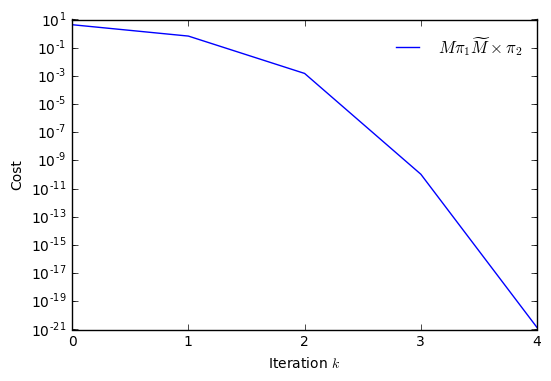

In [25]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_planes_diff_res['iterations'])['cost'], label=r'$M\pi_1\widetilde{M} \times \pi_2$')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')

### 4 residuals v

In [90]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_angle_error_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_v_res, summary_planes_v_res, _) = mes.solve()
print(summary_planes_v_res['brief_report'])
print(em_planes_v_res)

Ceres Solver Report: Iterations: 8, Initial cost: 7.908882e+00, Final cost: 4.397278e-17, Termination: CONVERGENCE
Mot: [ 0.87 1.9e-09 -0.5 -2.7e-09 -0.68 -0.43 -0.18 -0.25 ]


In [91]:
np.allclose(em_planes_v_res, motor)

True

### Plots

In [92]:
sns.set_style('whitegrid')
sns.set_context('paper')

NameError: name 'sns' is not defined

NameError: name 'summary_planes_v_res' is not defined

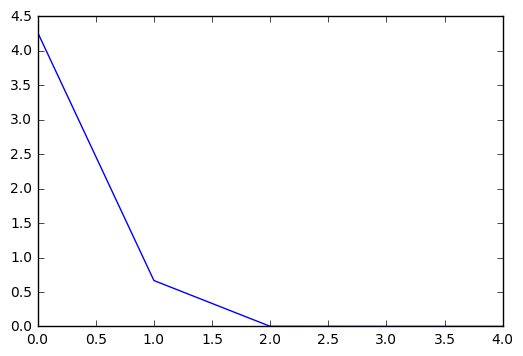

In [20]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_planes_diff_res['iterations'])['cost'], label=r'diff')
ax.plot(pd.DataFrame(summary_planes_v_res['iterations'])['cost'], label=r'support')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('planes-nonoise.pdf')

## Noise

### 4 residuals diff

In [27]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b_noisy):
    mes.add_dual_plane_difference_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_diff_res_noise, summary_planes_diff_res_noise, _) = mes.solve()
print(summary_planes_diff_res_noise['brief_report'])
print(em_planes_diff_res_noise)

Ceres Solver Report: Iterations: 5, Initial cost: 5.351252e+00, Final cost: 3.424196e-21, Termination: CONVERGENCE
Mot: [ 0.88 -5.1e-14 -0.47 -2.4e-14 -0.68 -0.44 -0.16 -0.23 ]


### 4 residuals v

In [95]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b_noisy):
    mes.add_dual_plane_angle_error_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_planes_v_res_noise, summary_planes_v_res_noise, _) = mes.solve()
print(summary_planes_v_res_noise['brief_report'])
print(em_planes_v_res_noise)

Ceres Solver Report: Iterations: 7, Initial cost: 7.478017e+00, Final cost: 5.779499e-17, Termination: CONVERGENCE
Mot: [ 0.88 1.5e-09 -0.47 -1.9e-09 -0.68 -0.44 -0.16 -0.23 ]


In [96]:
np.allclose(em_planes_diff_res_noise, em_planes_v_res_noise)

True

### Valkenburg and Dorst

In [97]:
vd = VDMotorEstimationSolver()
vd.add_dual_plane_observations(planes_a, planes_b_noisy)
vd_em_planes_noise = vd.solve()
print(vd_em_planes_noise)

NameError: name 'VDMotorEstimationSolver' is not defined

In [98]:
vd = VDMotorEstimationSolver()
vd.add_dual_plane_observations(planes_a, planes_b)
vd_em_planes = vd.solve()
print(vd_em_planes)

NameError: name 'VDMotorEstimationSolver' is not defined

NameError: name 'pd' is not defined

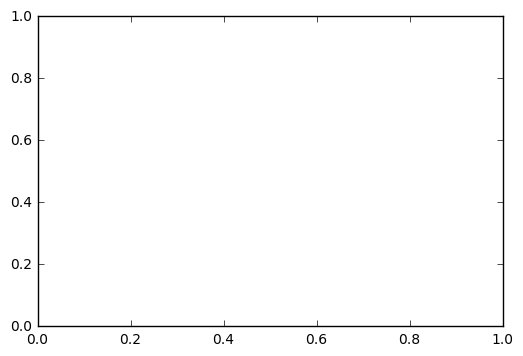

In [99]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_planes_diff_res_noise['iterations'])['cost'], label=r'diff')
ax.plot(pd.DataFrame(summary_planes_v_res_noise['iterations'])['cost'], label=r'support')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
plt.savefig('planes-noise.pdf')

# Visualization

In [72]:
scene = Scene(children=
#               [plane_mesh(plane,color=Colors.HOTPINK) for plane in planes_a[:2]] +\
              [plane_mesh(plane,color=Colors.LIGHTSKYBLUE) for plane in planes_b[:2]] +\
              [plane_mesh(plane,color='palegreen') for plane in planes_b_noisy[:2]] +\
              
#               [plane_mesh(plane.spin(vd_em_planes),color=Colors.HOTPINK) for plane in planes_a[:2]] +\
              [plane_mesh(plane.spin(em_planes_diff_res_noise), color=Colors.HOTPINK) for plane in planes_a[:2]] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
renderer.width = '1024'
renderer.height = '768'
display(renderer)